## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

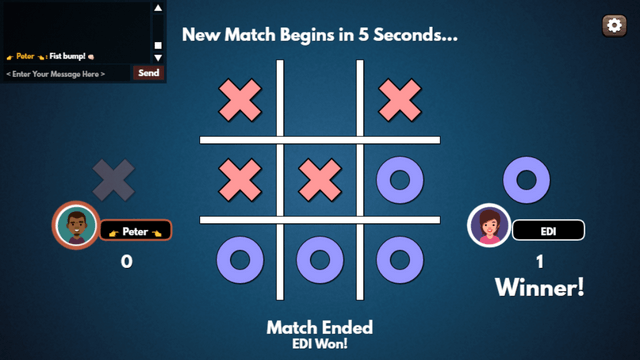

In [60]:
from IPython.display import Image
Image("D:/MSc-in-ML-&-Ai/Artificial Intelligence/RL/Assignment/unnamed.png", height = '100', width = '1000')

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [61]:
import collections
import numpy as np
import random
import pickle
import time
from TCGame_Env2 import TicTacToe
from matplotlib import pyplot as plt

In [64]:
env = TicTacToe()
curr_state = env.state
curr_action = random.choice(list(env.action_space(curr_state)[0]))
first_state, reward, terminated = env.step(curr_state, curr_action)
print('The Current State is : ', curr_state)
print('The Current Action is : ', curr_action)
print('The first_state, reward, terminated is : ', first_state, reward, terminated)
print('The State Transition is : ', env.state_transition(curr_state, curr_action)) 

The Current State is :  [nan, nan, nan, nan, nan, 6, nan, nan, 5]
The Current Action is :  (8, 5)
The first_state, reward, terminated is :  [nan, nan, nan, nan, nan, 6, nan, nan, 5] -1 Resume
The State Transition is :  [nan, nan, nan, nan, nan, 6, nan, nan, 5]


In [65]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [66]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [7]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [68]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()     
    if z > epsilon:
        States_Keys = Q_state(state)
        # Exploitation, where this will get the action which is corresponding to the max q-value of current state
        action = max(Q_dict[States_Keys],key=Q_dict[States_Keys].get)
    else:
        # Exploration, by randomly choosing an action
        possible_action = []
        for i in env.action_space(state)[0]:
            possible_action.append(i)
        action = possible_action[np.random.choice(range(len(possible_action)))]
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [70]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [76]:
# Initialise states to be tracked and will be plotted at a later stage
def initialise_tracking_states():
    # We will select 4 Q-values now
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-8-5-x-x-x-x',(5,1)),
                      ('x-3-x-x-x-x-2-x-x',(2,9)),('4-7-x-x-x-x-x-x-x',(3,1))]
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [77]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [78]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [79]:
initialise_tracking_states()

### Define hyperparameters ---write your code here

In [16]:
# Define hyperparameters for the training
EPISODES = 5000000
LR = 0.3
GAMMA = 0.9
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001
threshold = 10
policy_threshold = 300

### Q-update loop ---write your code here

In [18]:
start_time = time.time()

for episode in range(EPISODES):
    if (episode % 500000 == 0):
        print('Number of Episodes :', episode)
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
    done_episode = False
    add_to_dict(curr_state)
    while (done_episode != True):
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, done_temp = env.step(curr_state, curr_action)
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)
        if (done_temp == 'Win' or done_temp == 'Tie'):
            done_game = True
        else:
            done_game = False
        if (done_game != True):
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next]))) - Q_dict[curr_state1][curr_action])
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))
            done_episode = True
        curr_state = next_state
    if ((episode+1)%threshold)==0:
        save_tracking_states()
elapsed_time = time.time() - start_time
print('Total time took in seconds:', elapsed_time)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy_Q_dict')
save_obj(Q_dict,'Policy')

Episode Number: 0
Episode Number: 500000
Episode Number: 1000000
Episode Number: 1500000
Episode Number: 2000000
Episode Number: 2500000
Episode Number: 3000000
Episode Number: 3500000
Episode Number: 4000000
Episode Number: 4500000
Time duration in seconds: 4517.748470067978


#### Check the Q-dictionary

In [19]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.34049587679574567,
              (0, 3): -0.5881425998153357,
              (0, 5): 0.2049352969339897,
              (0, 7): -1.3882349856049836,
              (0, 9): 4.221450904962712,
              (1, 1): -1.537906193554058,
              (1, 3): -1.6467933210550092,
              (1, 5): 2.2599303973186102,
              (1, 7): -1.5061720889907801,
              (1, 9): 2.3618445341894345,
              (2, 1): -1.586659290090287,
              (2, 3): -1.4268070995844577,
              (2, 5): 0.7598427852395034,
              (2, 7): -1.5733958432011617,
              (2, 9): 0.8108778955445501,
              (3, 1): -1.615190108413035,
              (3, 3): -0.8898572231449924,
              (3, 5): -0.6408110995072367,
              (3, 7): -1.570820039502653,
              (3, 9): -1.409485928430517,
              (4, 1): -1.5588518912410332,
              (4, 3): -0.9005682893086779,
              (4, 5): -1.3

In [20]:
len(Q_dict)

395506

In [21]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

In [22]:
print(Q_dict['x-x-x-x-x-x-x-x-x'][6,5])

-0.9084735433856503


In [23]:
print(Q_dict['x-3-x-x-x-x-2-x-x'][2,9])

-3.357


In [24]:
print(Q_dict['x-x-x-8-5-x-x-x-x'][5,1])

-0.51


In [25]:
print(Q_dict['4-7-x-x-x-x-x-x-x'][3,1])

-0.8319300000000001


#### Check the states tracked for Q-values convergence
(non-evaluative)

In [26]:
# Write the code for plotting the graphs for state-action pairs tracked

<function matplotlib.pyplot.show(close=None, block=None)>

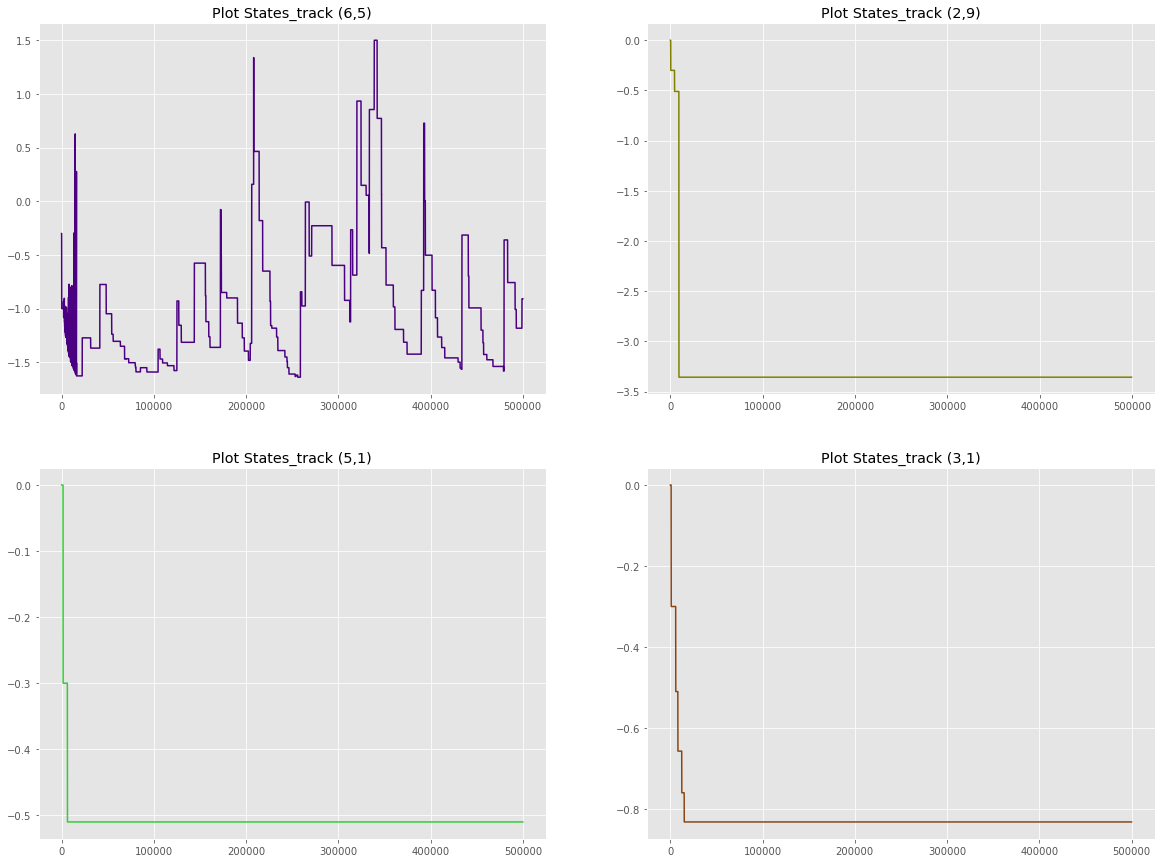

In [59]:
plt.figure(0, figsize=(20,15))
plt.style.use('ggplot')
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]), color = 'indigo')
plt.title('Plot States_track (6,5)')
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-x-x-2-x-x'][(2,9)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-x-x-2-x-x'][(2,9)]), color = 'olive')
plt.title('Plot States_track (2,9)')
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-8-5-x-x-x-x'][(5,1)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-8-5-x-x-x-x'][(5,1)]), color = 'limegreen')
plt.title('Plot States_track (5,1)')
plt.show

x_axis = np.asarray(range(0, len(States_track['4-7-x-x-x-x-x-x-x'][(3,1)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['4-7-x-x-x-x-x-x-x'][(3,1)]), color = 'saddlebrown')
plt.title('Plot States_track (3,1)')
plt.show

### Epsilon - decay check

In [32]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

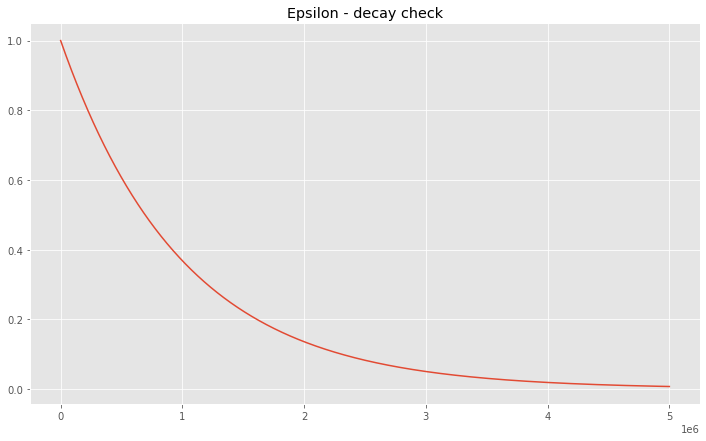

In [43]:
plt.figure(0, figsize=(12,7))
plt.style.use('ggplot')
plt.plot(time, epsilon)
plt.title('Epsilon - decay check')
plt.show()